<a href="https://colab.research.google.com/github/DasBlaueWunder/Homeworx/blob/main/Homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5

##CIFAR10

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
def show_examples(dataset, number):
  for i,(image, label) in enumerate(dataset.take(number)):
    title = "Example " + str(i) + ": Shape = "+ str(image.shape) + ", Label = " + str(label.numpy())
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.show()

### 1. Load data set and preprocess

Load the data set and explore.
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBMNIAR/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBMNIAR/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


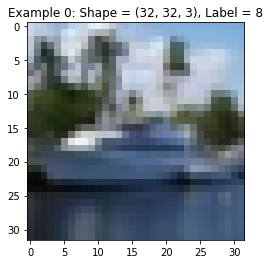

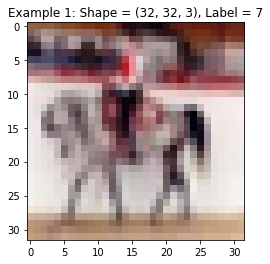

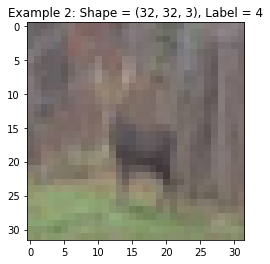

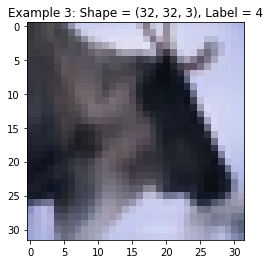

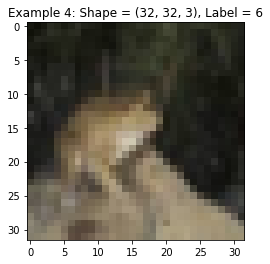

In [ ]:
# Load train and test data set as shuffled subsets of the cifar10 data set
train_dataset, test_dataset = tfds.load('cifar10', as_supervised=True, split = ['train', 'test'], shuffle_files = True)
assert isinstance(train_dataset, tf.data.Dataset)

# Show some examples
show_examples(train_dataset, 5)

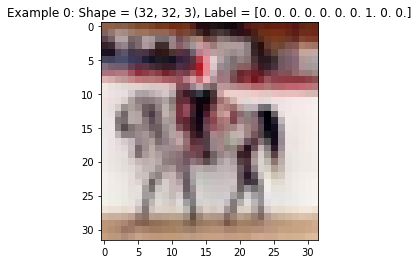

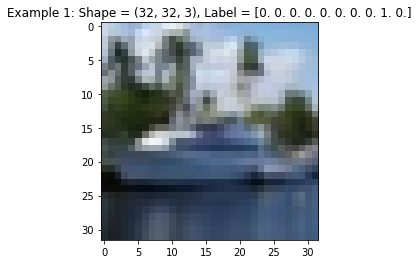

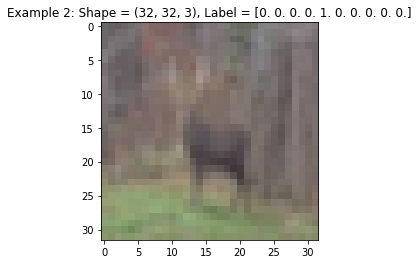

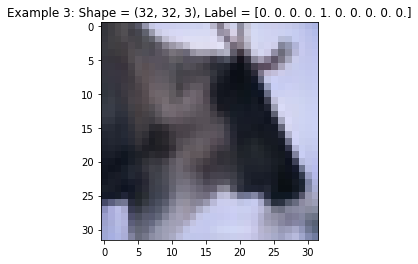

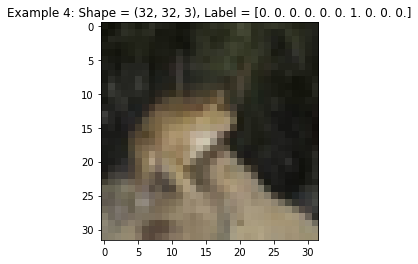

In [ ]:
# Normalize it and use One-hot-encoding for the labels for better results
def preprocess(dataset):
  dataset = dataset.map(lambda image, label: (image/255,tf.one_hot(label,10)))
  return dataset

train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)

# Show some examples (just to control, if everything has been done correctly)
show_examples(train_dataset, 5)

# Batching and fetching
# Another shuffle (buffer_size should be greater equal data set size)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(100).prefetch(1)
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(10).prefetch(1)

## 2. Model

This weeks homework makes use of a Convolutional Neural Network architecture like last week.

Additionally, we will make use of some regularization techniques like l2-regularization, dropout and batch normalization.

Hence, we use a network like:

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                                               activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)) # L2-regularized kernel
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.dropout_1 = tf.keras.layers.Dropout(0.1) # Dropout with rate of 10%
        self.conv_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same',
                                               strides=(2,2), activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.dropout_2 = tf.keras.layers.Dropout(0.1)
        self.conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same',
                                               strides=(3,3), activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))
        self.max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout_3 = tf.keras.layers.Dropout(0.1)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization() # Batch normalization
        self.dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()
        self.dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)
        self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)

    def call(self, x, training):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.dropout_1(x, training)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.dropout_2(x, training)
        x = self.conv_4(x)
        x = self.max_pool_3(x)
        x = self.global_pool(x)
        x = self.dropout_3(x, training)
        x = self.batch_norm_3(x, training)
        x = self.dense_1(x)
        x = self.batch_norm_4(x, training)
        x = self.dense_2 (x)
        x = self.output_layer(x)
        return x

## 3. Training
Train with Adam for 30 epochs with a learning rate of 0.001, while the loss is categorical cross entropy.

In [ ]:
def train_step(model, input, target, loss_function, optimizer, training = True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses) # add L2-losses to general loss
    gradients = tape.gradient(loss, model.trainable_variables)
    accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    accuracy = np.mean(accuracy)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy

def test(model, test_data, loss_function, training = False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001

# Initialize the model.
model = Model()
# Initialize the loss for binary classification
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=1000)
    test_dataset = test_dataset.shuffle(buffer_size=1000)

    #training (and checking in with training)
    for (input,target) in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Show accuracy
    print('Current accuracy: ' + test_accuracy)

## 4. Visualization
Visualize both accuracy and loss for training and test data.

With regularization we retrieved up to 73% accuracy, while the network only reaches 69% accuracy without these regularization techniques.

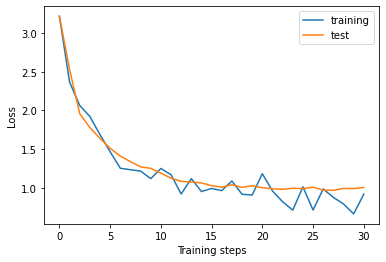

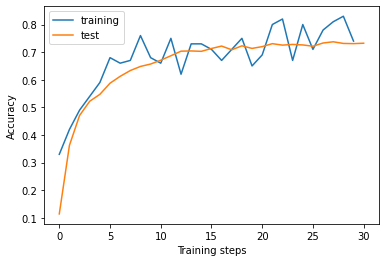

Accuracy: 0.7323


In [ ]:
%matplotlib inline

# Loss (in one plot)
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Accuracy
plt.figure()
line1, = plt.plot(train_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()

print('Accuracy: '+ str(test_accuracies[-1]))